In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define data paths
train_data_dir = r'C:\Users\AvishkaB\Desktop\DL\archive\train'
test_data_dir = r'C:\Users\AvishkaB\Desktop\DL\archive\test'
train_csv_path = r'C:\Users\AvishkaB\Desktop\DL\archive\Training_set.csv'
test_csv_path = r'C:\Users\AvishkaB\Desktop\DL\archive\Testing_set.csv'

In [3]:
# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
# Initialize a LabelEncoder to convert class labels to numerical values
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])

In [5]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [7]:
# Create data generators
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_data_dir,
    x_col='filename',
    y_col='label',  # Change this to 'label'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse'
)


Found 6499 validated image filenames belonging to 75 classes.


In [8]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_data_dir,
    x_col='filename',
    y_col=None,  # Set y_col to None since there are no labels in the test data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,  # Set class_mode to None
    shuffle=False
)

Found 2786 validated image filenames.


In [9]:
# Load the DenseNet pre-trained on ImageNet without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False)

In [10]:
# Add a global average pooling layer and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units as needed
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [11]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
204/204 [==============================] - 269s 1s/step - loss: 3.2981 - accuracy: 0.3080 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
204/204 [==============================] - 272s 1s/step - loss: 1.5499 - accuracy: 0.7113 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
204/204 [==============================] - 277s 1s/step - loss: 0.9398 - accuracy: 0.8120 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
204/204 [==============================] - 274s 1s/step - loss: 0.7128 - accuracy: 0.8474 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
204/204 [==============================] - 281s 1s/step - loss: 0.5807 - accuracy: 0.8720 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
204/204 [==============================] - 280s 1s/step - loss: 0.5032 - accuracy: 0.8849 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
204/204 [==============================] - 280s 1s/step - loss: 0.4550 - accuracy: 

In [17]:
# Save the entire model to a file
model.save('butterfly_classifier.h5')
model.save('butterfly_classifier.keras')

In [20]:
model.load_weights('butterfly_classifier.h5')  # You should specify the correct path to your trained model weights

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


In [19]:
predictions = model.predict(test_generator)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Add predicted labels to the test dataframe
test_df['predicted_label'] = predicted_labels

# Save the dataframe with predictions to a CSV file
test_df.to_csv('test_predictions.csv', index=False)


88/88 [==============================] - 101s 1s/step


In [25]:
import matplotlib.pyplot as plt


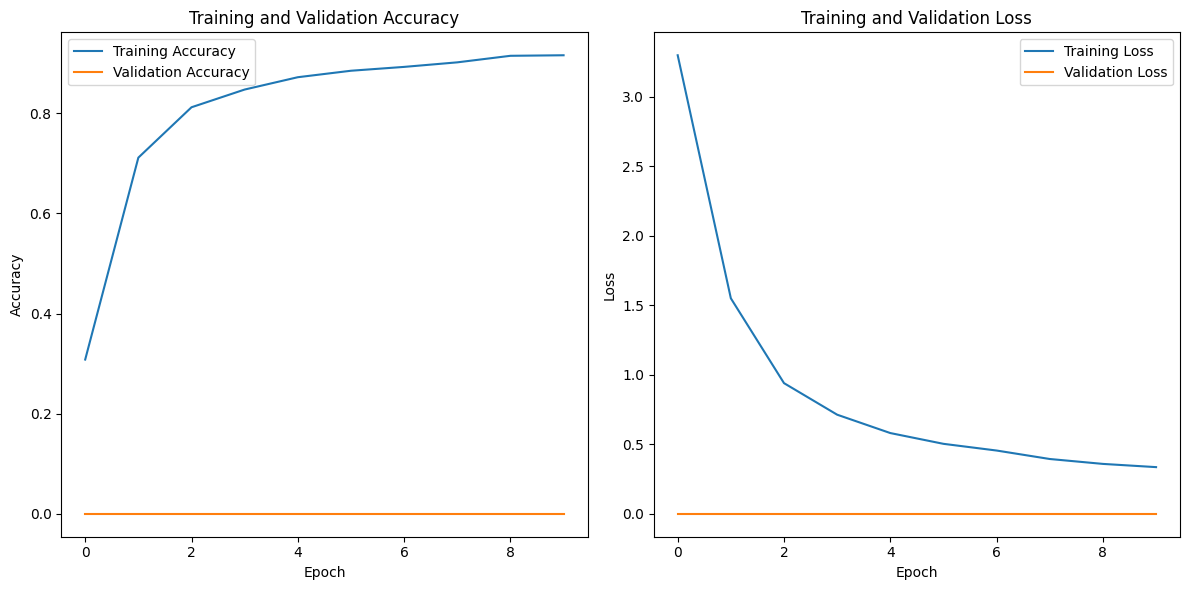

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()